In [1]:
import matplotlib.pyplot as plt
import warnings


import pandas as pd
import numpy as np
import os
import seaborn as sns

from time import time

import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim


!pip install torchsummary
from torchsummary import summary

#!pip install torchviz
#from torchviz import make_dot, make_dot_from_trace


warnings.filterwarnings('ignore')

In [2]:
#dataset=pd.read_csv("/content/drive/MyDrive/Datasets/CSE4238_SoftComputing_Assignment_3_Dataset_3.csv",encoding='latin1')
dataset_raw = pd.read_csv('/content/drive/MyDrive/Datasets/CSE4238_SoftComputing_Assignment_3_Dataset_3.csv', encoding = "ISO-8859-1")

In [3]:
#dataset.head()
#dataset.sample(5)
dataset_raw.head()

,tweets,sentiment
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [4]:
dataset_raw['sentiment'].value_counts()

0    8000
1    2314
Name: sentiment, dtype: int64

# Dataset PreProcessing

- [NLTK](https://www.nltk.org/)
- [spaCy ](https://spacy.io/)

**NLTK & spaCy** is a free open-source library for Natural Language Processing (NLP) in Python to support teaching, research, and development. Which are:- 
  - Free and Open source
  - Easy to use
  - Modular
  - Well documented
  - Simple and extensible

In this notebook, I will provide basic NLP tasks that we need in order to process raw text to find useful informations. For each tasks, we will be using NLTK as well as spaCy. Good news is that both are installed in Google Colab by default. 

Some definitions

    Corpus - Corpora is the plural of Corpus. "Corpus" mainly appears in NLP area or application domain related to texts/documents, because of its meaning "a collection of written texts"
        Example: A collection of news documents.

    Dataset - dataset appears in every application domain (in can be image/video/text/numerical/mixed) --- a collection of any kind of data is a dataset.

    Lexicon - vocabulary or list of Words and their meanings.
        Example: English dictionary.

    Token - Each "entity" that is a part of whatever was split up based on rules.
        For examples, each word is a token when a sentence is "tokenized" into words. Each sentence can also be a token, if you tokenized the sentences out of a paragraph.


## Tokenization

In order to feed our text data to a classification model, we first need to tokenize it.
Tokenization is the process of splitting up a single string of text into a list of individual words, or tokens.

Python has a built in string method: string.split(), that splits up any given string into a list based on a splitting character (if not specified, will default to white space).

In this example, we will use the TweetTokenizer; a Twitter-aware tokenizer provided by the nltk library. In addition to a standard tokenizer, this tokenizer will split the input text based on various criterions that are well suited for the tweets use case.

More info can be found at: https://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize.casual.

In [5]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = dataset_raw['tweets'].tolist()
Y = dataset_raw['sentiment'].tolist()

# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x, y in zip(X, Y):
    if y == 1:
        data.append((tk.tokenize(x), 1))
    else:
        data.append((tk.tokenize(x), 0))
        
# Printing the CPU time and the first 5 elements of our 'data' list
print('CPU Time:', time() - start_time)
data[:10]

CPU Time: 1.434776782989502


[(['just',
   'had',
   'a',
   'real',
   'good',
   'moment',
   '.',
   'i',
   'misss',
   'him',
   'so',
   'much',
   ','],
  0),
 (['is', 'reading', 'manga', 'http://plurk.com/p/mzp1e'], 0),
 (['@comeagainjen',
   'http://twitpic.com/2y2lx',
   '-',
   'http://www.youtube.com/watch?v=zoGfqvh2ME8'],
  0),
 (['@lapcat',
   'Need',
   'to',
   'send',
   "'",
   'em',
   'to',
   'my',
   'accountant',
   'tomorrow',
   '.',
   'Oddly',
   ',',
   'I',
   "wasn't",
   'even',
   'referring',
   'to',
   'my',
   'taxes',
   '.',
   'Those',
   'are',
   'supporting',
   'evidence',
   ',',
   'though',
   '.'],
  0),
 (['ADD', 'ME', 'ON', 'MYSPACE', '!', '!', '!', 'myspace.com/LookThunder'], 0),
 (['so', 'sleepy', '.', 'good', 'times', 'tonight', 'though'], 0),
 (['@SilkCharm',
   're',
   ':',
   '#nbn',
   'as',
   'someone',
   'already',
   'said',
   ',',
   'does',
   'fiber',
   'to',
   'the',
   'home',
   'mean',
   'we',
   'will',
   'all',
   'at',
   'least',
   'be'

## Lemmatization

According to the Cambridge English Dictionary, Lemmatization is the process of reducing the different forms of a word to one single form, for example, reducing "builds", "building", or "built" to the lemma "build". This will greatly help our classifier by treating all variants of a given word as being references to the original lemma word. For example, it will avoid interpreting "running" and "run" as completely different inputs.

In this example, we will use nltk's WordNetLemmatizer to accomplish this task. This lemmatizer however takes as input two arguments: a list of tokens to be lemmatized as well as their corresponding part of speech. The most common parts of speech in english are nouns and verbs. In order to extract each token's part of speech, we will utilize nltk's post_tag function, that takes an input a list of tokens, and returns a list of tuples, where each tuple is composed of a token and its corresponding position tag. Various position tags can be outputted from the pos_tag function, however the most notable ones are:

    NNP: Noun, proper, singular
    NN: Noun, common, singular or mass.
    VBG: Verb, gerund or present participle.
    VBN: Verb, past participle.


A full list of position tags can be found at: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

### Stemming VS Lemmatization

https://www.geeksforgeeks.org/introduction-to-stemming/
Stemming is the process of producing morphological variants of a root/base word. Stemming programs are commonly referred to as stemming algorithms or stemmers. A stemming algorithm reduces the words “chocolates”, “chocolatey”, “choco” to the root word, “chocolate” and “retrieval”, “retrieved”, “retrieves” reduce to the stem “retrieve”. Stemming is an important part of the pipelining process in Natural language processing. The input to the stemmer is tokenized words. How do we get these tokenized words? Well, tokenization involves breaking down the document into different words. To know in detail about tokenization and its working refer the article :https://www.geeksforgeeks.org/nlp-how-tokenizing-text-sentence-words-works/

Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meaning to one word.

Text preprocessing includes both Stemming as well as Lemmatization. Many times people find these two terms confusing. Some treat these two as same. Actually, lemmatization is preferred over Stemming because lemmatization does morphological analysis of the words.

One major difference with stemming is that lemmatize takes a part of speech parameter, “pos” If not supplied, the default is “noun.”

In [6]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# For tokenizing words and sentences
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
nltk.download('averaged_perceptron_tagger')
# Previewing the pos_tag() output
print(pos_tag(data[0][0]))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[('just', 'RB'), ('had', 'VBD'), ('a', 'DT'), ('real', 'JJ'), ('good', 'JJ'), ('moment', 'NN'), ('.', '.'), ('i', 'JJ'), ('misss', 'VBP'), ('him', 'PRP'), ('so', 'RB'), ('much', 'RB'), (',', ',')]


In [8]:
def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        # First, we will convert the pos_tag output tags to a tag format that the WordNetLemmatizer can interpret
        # In general, if a tag starts with NN, the word is a noun and if it stars with VB, the word is a verb.
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

# Previewing the WordNetLemmatizer() output
print(lemmatize_sentence(data[0][0]))

['just', 'have', 'a', 'real', 'good', 'moment', '.', 'i', 'miss', 'him', 'so', 'much', ',']


## Cleaning the Data

In [9]:
import re, string

# Stopwords are frequently-used words (such as “the”, “a”, “an”, “in”) that do not hold any meaning useful to extract sentiment.
# If it's your first time ever using nltk, you can download nltk's stopwords using: nltk.download('stopwords')
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')

# A custom function defined in order to fine-tune the cleaning of the input text. This function is highly dependent on each usecase.
# Note: Only include misspelling or abbreviations of commonly used words.
#       Including many minimally present cases would negatively impact the performance. 
def cleaned(token):
    if token == 'frm':
        return 'from'
    if token == 'earl':
        return 'early'
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == 'tnx':
        return 'thanks'
    if token == 'yay':
        return 'yes'
    if token == 'lol':
        return 'funny'        
    if token == 'ty':
        return 'thank you'        
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token == '#':
        return ''
    if token == 'amp' or token == 'quot' or token == 'lt' or token == 'gt' or token == '½25':
        return ''
    return token

# This function will be our all-in-one noise removal function
def remove_noise(tweet_tokens):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        # Eliminating the token if it is a link
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        #Eliminating the token if it is a mention
        token = re.sub("#(w+)","", token)


        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        cleaned_token = cleaned(token.lower())
        
        # Eliminating the token if its length is less than 3, if it is a punctuation or if it is a stopword
        if cleaned_token not in string.punctuation and len(cleaned_token) > 2 and cleaned_token not in STOP_WORDS:
            cleaned_tokens.append(cleaned_token)
            
    return cleaned_tokens

# Prevewing the remove_noise() output
print(remove_noise(data[0][0]))

['real', 'good', 'moment', 'miss', 'much']


# Visualizing the Data

Word Clouds are one of the best visualizations for words frequencies in text documents.
Essentially, what it does is that it produces an image with frequently-appearing words in the text document, where the most frequent words are showcased with bigger font sizes, and less frequent words with smaller font sizes.

In [10]:
#X = dataset_raw['tweets'].tolist()
#Y = dataset_raw['sentiment'].tolist()

start_time = time()


cleaned_tokens_list = []

# Removing noise from all the data
for tokens, label in data:
    cleaned_tokens_list.append((remove_noise(tokens), label))

'''
# As the Naive Bayesian classifier accepts inputs in a dict-like structure,
# we have to define a function that transforms our data into the required input structure

def list_to_dict(cleaned_tokens):
    return dict([token, True] for token in cleaned_tokens)

print('Removed Noise, CPU Time:', time() - start_time)
start_time = time()

final_data = []

# Transforming the data to fit the input structure of the Naive Bayesian classifier
for tokens, label in cleaned_tokens_list:
    final_data.append((list_to_dict(tokens), label))
    
print('Data Prepared for model, CPU Time:', time() - start_time)

# Previewing our final (tokenized, cleaned and lemmatized) data list
final_data[:5]
'''

"\n# As the Naive Bayesian classifier accepts inputs in a dict-like structure,\n# we have to define a function that transforms our data into the required input structure\n\ndef list_to_dict(cleaned_tokens):\n    return dict([token, True] for token in cleaned_tokens)\n\nprint('Removed Noise, CPU Time:', time() - start_time)\nstart_time = time()\n\nfinal_data = []\n\n# Transforming the data to fit the input structure of the Naive Bayesian classifier\nfor tokens, label in cleaned_tokens_list:\n    final_data.append((list_to_dict(tokens), label))\n    \nprint('Data Prepared for model, CPU Time:', time() - start_time)\n\n# Previewing our final (tokenized, cleaned and lemmatized) data list\nfinal_data[:5]\n"

Positive words


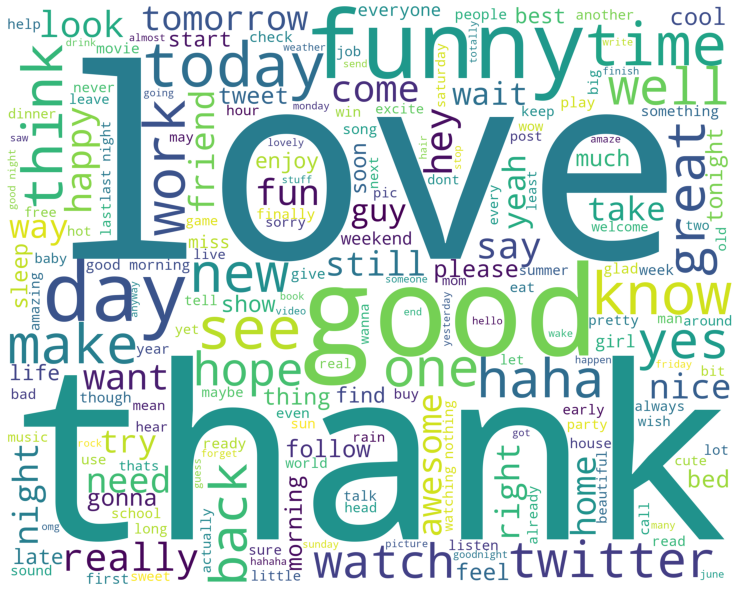

Negative words


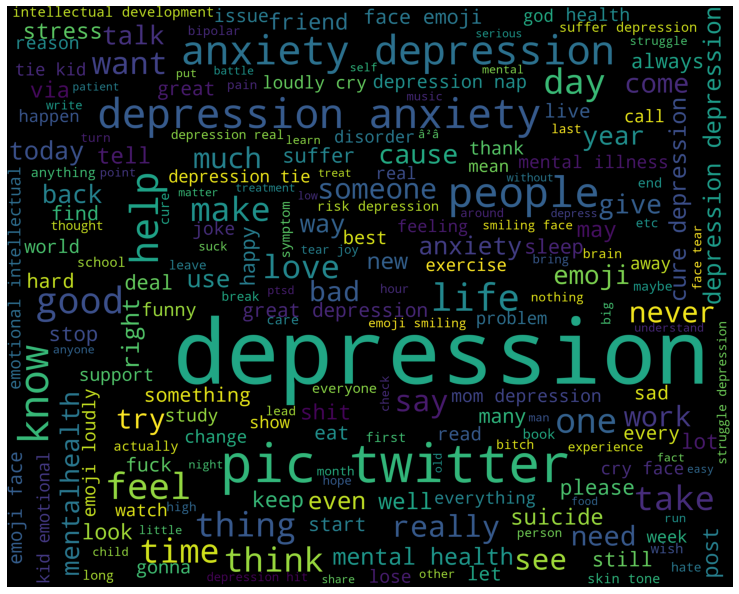

CPU Time: 43.56684756278992


In [11]:
start_time = time()

from wordcloud import WordCloud, STOPWORDS

positive_words = []
negative_words = []

# Separating out positive and negative words (i.e., words appearing in negative and positive tweets),
# in order to visualize each set of words seperately
for i in range(len(cleaned_tokens_list)):
    if cleaned_tokens_list[i][1] == 0:
        positive_words.extend(cleaned_tokens_list[i][0])
    else:
        negative_words.extend(cleaned_tokens_list[i][0])

# Defining our word cloud drawing function
def wordcloud_draw(data, color = 'black'):
    wordcloud = WordCloud(stopwords = STOPWORDS,
                          background_color = color,
                          width = 2500,
                          height = 2000
                         ).generate(' '.join(data))
    plt.figure(1, figsize = (13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(positive_words, 'white')
print("Negative words")
wordcloud_draw(negative_words)        

print('CPU Time:', time() - start_time)

In [12]:
print(len(positive_words));
print(len(negative_words));
print(len(cleaned_tokens_list))

53341
28959
10314


In [13]:
def cntFrequency(lst1,lst2):
    dct=dict(Counter(lst2))
    sub_dct={k:dct.get(k,0) for k in lst1}
    return sub_dct

In [14]:
from collections import Counter

cnt_dct=cntFrequency(positive_words,negative_words)
print(cnt_dct);
print(sum(cnt_dct.values()))

{'real': 56, 'good': 124, 'moment': 10, 'miss': 13, 'much': 79, 'read': 35, 'manga': 0, 'need': 72, 'send': 12, 'accountant': 0, 'tomorrow': 8, 'oddly': 0, 'even': 56, 'refer': 3, 'tax': 3, 'support': 33, 'evidence': 9, 'though': 14, 'add': 18, 'myspace': 0, 'myspace.com/lookthunder': 0, 'sleepy': 5, 'time': 114, 'tonight': 8, '#nbn': 0, 'someone': 79, 'already': 19, 'say': 84, 'fiber': 0, 'home': 16, 'mean': 30, 'least': 13, 'regular': 6, '24ã': 0, 'â½c': 0, 'possible': 5, 'today': 54, 'nice': 13, 'nite': 0, 'twitterville': 0, 'workout': 1, 'ciao': 0, 'night': 24, 'darlin': 0, 'sweet': 0, 'dream': 7, 'morning': 7, 'everybody': 3, 'finally': 13, 'create': 10, 'wordpress': 0, 'blog': 13, "there's": 22, 'seattle': 0, 'coffee': 6, 'community': 6, '...': 192, 'kisha': 0, 'cnt': 0, 'get': 221, 'til': 2, 'remember': 12, 'top': 8, 'yes': 12, 'band': 1, 'awesome': 6, 'please': 43, 'reply': 4, 'really': 85, 'love': 92, 'reflection': 0, 'shadow': 2, 'ooo': 0, 'fantasy': 0, 'like': 209, 'novel': 

## Global Vectors for Word Representation (GloVe)

In [15]:
# Downloading and unzipping the glove word embeddings from the official website

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-09-25 15:21:43--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-09-25 15:21:43--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-09-25 15:21:43--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [16]:
# Defining a handy function in order to load a given glove file

def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [17]:
# Loading the 50-dimensional GloVe embeddings
# This method will return three dictionaries:
# * word_to_index: a dictionary mapping from words to their indices in the vocabulary
# * index_to_word: dictionary mapping from indices to their corresponding words in the vocabulary
# * word_to_vec_map: dictionary mapping words to their GloVe vector representation
# Note that there are 400,001 words, with the valid indices ranging from 0 to 400,000

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [18]:
word_to_index['just']

200035

In [19]:
word_to_vec_map['just']

array([ 0.17698 ,  0.065221,  0.28548 , -0.4243  ,  0.7499  , -0.14892 ,
       -0.66786 ,  0.11788 , -0.45411 ,  0.1854  , -0.65107 , -0.43436 ,
       -0.601   , -0.11323 ,  0.85217 ,  0.25333 ,  0.31332 ,  0.059113,
       -0.88746 , -0.46554 , -0.30104 ,  0.70689 ,  0.4508  ,  0.14714 ,
        0.68951 , -1.849   , -0.23012 ,  0.67376 ,  1.0314  , -0.82298 ,
        3.6701  ,  0.62587 , -0.17666 ,  0.22468 , -0.029079, -0.25751 ,
        0.12939 ,  0.44485 ,  0.52806 , -0.35906 , -0.27806 ,  0.20667 ,
        0.076161,  0.32197 , -0.40589 ,  0.23199 ,  0.20909 , -0.29776 ,
        0.11035 ,  0.22057 ])



As this word embedding only considers 400,000 unique words, it might encounter words it has never seen before. For example, the word "LSTM" is most likely not included in those 400,000 words.

In order to overcome such scenarios, word embeddings reserve an extra spot for "unknown" words, also denoted with the keyword unk.


In [20]:
word_to_index['unk']

372306

Note that the cosine similarity return values between -1 and +1, where -1 denote completely opposite meanings, +1 denote completely identical meanings and 0 denote totally unrelated meanings.

In [21]:
def cosine_similarity(u, v):
    dot = np.dot(u, v)
    norm_u = np.sqrt(np.sum(u**2))
    norm_v = np.sqrt(np.sum(v**2))
    cosine_similarity = dot / (norm_u * norm_v)
    
    return cosine_similarity



In [22]:
cosine_similarity(word_to_vec_map['foolishness'], word_to_vec_map['stupidity'])

0.8324980555151155

In [23]:
cosine_similarity(word_to_vec_map['burger'], word_to_vec_map['pen'])

0.15063344330869446

In [24]:
cosine_similarity(word_to_vec_map['cucumber'], word_to_vec_map['phone'])

-0.012485506721235957

## Data Padding

In [25]:
start_time = time()

unks = []
UNKS = []

# This function will act as a "last resort" in order to try and find the word
# in the words embedding layer. It will basically eliminate contiguously occuring
# instances of a similar character
def cleared(word):
    res = ""
    prev = None
    for char in word:
        if char == prev: continue
        prev = char
        res += char
    return res


def sentence_to_indices(sentence_words, word_to_index, max_len, i):
    global X, Y
    sentence_indices = []
    for j, w in enumerate(sentence_words):
        try:
            index = word_to_index[w]
        except:
            UNKS.append(w)
            w = cleared(w)
            try:
                index = word_to_index[w]
            except:
                index = word_to_index['unk']
                unks.append(w)
        X[i, j] = index


# Here we will utilize the already computed 'cleaned_tokens_list' variable
   
print('Removed Noise, CPU Time:', time() - start_time)
start_time = time()

list_len = [len(i) for i, j in cleaned_tokens_list]
max_len = max(list_len)
print('max_len:', max_len)

X = np.zeros((len(cleaned_tokens_list), max_len))
Y = np.zeros((len(cleaned_tokens_list), ))

for i, tk_lb in enumerate(cleaned_tokens_list):
    tokens, label = tk_lb
    sentence_to_indices(tokens, word_to_index, max_len, i)
    Y[i] = label
    
print('Data Prepared for model, CPU Time:', time() - start_time)


print(X[:5])
print(Y[:5])

Removed Noise, CPU Time: 0.0005211830139160156
max_len: 59
Data Prepared for model, CPU Time: 0.07158398628234863
[[302292. 164328. 248238. 246253. 251645.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.]
 [302207. 232946.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.    

## Building the Model

In [26]:
import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split

In [27]:
# Defining a function that will initialize and populate our embedding layer

def pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len):
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["unk"].shape[0] #50
    
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
        
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False, input_shape=(max_len,))
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [28]:
# Defining a sequencial model composed of firstly the embedding layer, than a pair of Bidirectional LSTMs,
# that finally feed into a sigmoid layer that generates our desired output betwene 0 and 1.
import os.path

model = Sequential()

model.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model.add(Dense(units=1, activation='sigmoid'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 59, 50)            20000050  
_________________________________________________________________
bidirectional (Bidirectional (None, 59, 256)           183296    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 20,577,843
Trainable params: 577,793
Non-trainable params: 20,000,050
_________________________________________________________________


In [29]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
#/content/drive/MyDrive/Untitled Folder

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

In [31]:
len(X_train)

8251

In [32]:
len(X_test)

2063

In [33]:
# Setting a batch size of 20 and training our model for 20 epochs
import os.path

model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 20, batch_size = 128, shuffle=True)

if os.path.isfile('/content/drive/MyDrive/Colad_ModelsSave/CSE4238_Assignment_3.h5') is False:
  model.save('/content/drive/MyDrive/Colad_ModelsSave/CSE4238_Assignment_3.h5')

Epoch 1/20
65/65 [==============================] - 18s 98ms/step - loss: 0.1878 - accuracy: 0.9269 - val_loss: 0.0800 - val_accuracy: 0.9733
Epoch 2/20
65/65 [==============================] - 5s 70ms/step - loss: 0.0448 - accuracy: 0.9870 - val_loss: 0.0486 - val_accuracy: 0.9864
Epoch 3/20
65/65 [==============================] - 5s 70ms/step - loss: 0.0355 - accuracy: 0.9896 - val_loss: 0.0428 - val_accuracy: 0.9884
Epoch 4/20
65/65 [==============================] - 5s 71ms/step - loss: 0.0297 - accuracy: 0.9912 - val_loss: 0.0418 - val_accuracy: 0.9874
Epoch 5/20
65/65 [==============================] - 5s 70ms/step - loss: 0.0276 - accuracy: 0.9921 - val_loss: 0.0388 - val_accuracy: 0.9884
Epoch 6/20
65/65 [==============================] - 5s 71ms/step - loss: 0.0253 - accuracy: 0.9925 - val_loss: 0.0361 - val_accuracy: 0.9893
Epoch 7/20
65/65 [==============================] - 5s 71ms/step - loss: 0.0251 - accuracy: 0.9927 - val_loss: 0.0390 - val_accuracy: 0.9893
Epoch 8/20
6

In [ ]:
#from tensorflow.keras.models import load_model
#saved_model= load_model('/content/drive/MyDrive/Colad_ModelsSave/CSE4238_Assignment_3.h5')

In [ ]:
#saved_model.summary()

In [ ]:
#saved_model.get_weights()

# Plotting

In [34]:
# Defnining a handy function in order to plot various models accuracy and loss progress

def plot_acc_loss(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'b', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

   

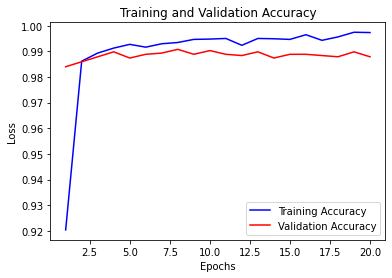

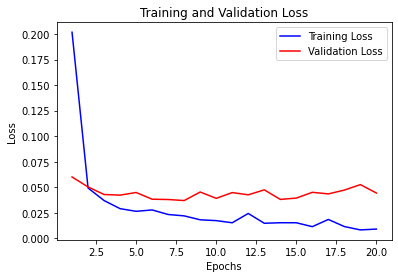

In [ ]:
 plot_acc_loss(model.history)

# Unknown Words

In [35]:
unk = word_to_index['unk']

n_unk_words = 0

for x in X:
    for y in x:
        if y == unk:
            n_unk_words += 1
n_unk_words



8123

In [36]:
from collections import Counter
Counter(unks).most_common(50)

[("i'm", 809),
 ('ã\x82â', 685),
 ('emoji', 343),
 ("can't", 189),
 ("i'l", 176),
 ('#depresion', 175),
 ("that's", 161),
 ("i've", 153),
 ('#mentalhealth', 61),
 ("we're", 60),
 ("i'd", 59),
 ('#anxiety', 54),
 ('lmao', 49),
 ("he's", 47),
 ('hahaha', 47),
 ("there's", 44),
 ("what's", 39),
 ("they're", 38),
 ("mom's", 35),
 ("let's", 32),
 ('#folowfriday', 26),
 ('â²â', 23),
 ('hahahaha', 22),
 ("we'l", 22),
 ('hahah', 20),
 ("ain't", 20),
 ('idk', 20),
 ("here's", 18),
 ('bday', 17),
 ("it'l", 17),
 ('â½ã', 15),
 ("y'al", 14),
 ('â¾ã', 14),
 ('âµã', 14),
 ('#mcflyforgermany', 13),
 ('w.tweterader.com', 13),
 ('#health', 13),
 ("mother's", 12),
 ('#fb', 12),
 ("who's", 12),
 ('thanx', 11),
 ("today's", 11),
 ('tweps', 11),
 ('. .', 11),
 ("how's", 11),
 ('#mentalilnes', 11),
 ('#bipolar', 11),
 ('#mentalhealthawarenes', 11),
 ('#ptsd', 11),
 ('#suicide', 11)]

# Predicting on Custom Data

In [37]:
def sentence_to_indices(sentence_words, max_len):
    X = np.zeros((max_len))
    sentence_indices = []
    for j, w in enumerate(sentence_words):
        try:
            index = word_to_index[w]
        except:
            w = cleared(w)
            try:
                index = word_to_index[w]
            except:
                index = word_to_index['unk']
        X[j] = index
    return X

def predict_custom_tweet_sentiment(custom_tweet):
    # Convert the tweet such that it can be fed to the model
    x_input = sentence_to_indices(remove_noise(tk.tokenize(custom_tweet)), max_len)
    
    # Retrun the model's prediction
    #return model.predict(np.array([x_input])).item()
    if (model.predict(np.array([x_input])).item()) < 0.5:
      print(f'{model.predict(np.array([x_input])).item():0.3}: Positive sentiment')
      return 0
    else:
      print(f'{model.predict(np.array([x_input])).item():0.3}: Negative sentiment')
      return 1

In [38]:
predict_custom_tweet_sentiment("I'm happy you're here!")

0.000325: Positive sentiment


0

In [39]:
predict_custom_tweet_sentiment("so excited 2day, looking 4ward 2 my long weekend ")

7.5e-06: Positive sentiment


0

In [40]:
predict_custom_tweet_sentiment("I'm in depression")


1.0: Negative sentiment


1

In [41]:
predict_custom_tweet_sentiment("My mom died last week. I don't have any relatives. I'm alone and it is so hard. Today is the first day without anxiety and depression. I wanna live, I will not give up, I will fight like my mother did.")

1.0: Negative sentiment


1

In [ ]:
predict_custom_tweet_sentiment("anxiety")

0.998: Negative sentiment


1

In [ ]:
(negative_words + positive_words).count('love')

632

In [ ]:
(negative_words + positive_words).count('happy')

256

In [ ]:
(negative_words + positive_words).count('infatuated')

0

# Confusion Matris

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score


In [43]:
y_pred = model.predict(X_test)
#Classification metrics can't handle a mix of binary and continuous targets
y_pred = (y_pred > 0.5)

In [45]:
# confusion matrix
cm = confusion_matrix(Y_test, y_pred)
print(cm)

[[1597    3]
 [  21  442]]


In [46]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [47]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test,y_pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(Y_test,y_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(Y_test,y_pred)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test,y_pred)
print('F1 score: %f' % f1)


Accuracy: 0.988366
Precision: 0.993258
Recall: 0.954644
F1 score: 0.973568


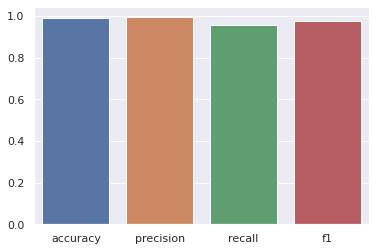

In [48]:
import seaborn as sns
sns.set()
scores = ['accuracy','precision','recall','f1']
values = [accuracy,precision,recall,f1]
sns.barplot(x=scores,y=values)

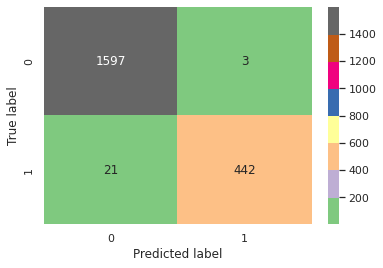

In [49]:
sns.heatmap(cm, annot=True, fmt="d", cmap ="Accent") # font size
plt.xlabel("Predicted label") 
plt.ylabel("True label") 
plt.show()

# Inspecting Wrongly Predicted Data

In [50]:
def i_to_sentence(I):
    sentence = ""
    for i in I:
        if i:
            sentence += index_to_word[int(i)] + " "
        else:
            break
    return sentence

In [51]:
C = 0

pred = model.predict(X_test)

for i in range(len(X_test)):
    final_pred = 1 if pred[i] > 0.5 else 0
    
    if(final_pred != Y_test[i]):
        print('Expected sentiment: ' + str(int(Y_test[i])) + '. Input: ' + i_to_sentence(X_test[i]))
        C += 1
        
    if C > 100:
        break

Expected sentiment: 1. Input: give read great unk unk unk unk unk unk 
Expected sentiment: 1. Input: unk bernanke federal reserve cause great unk chief say unk sorry 
Expected sentiment: 1. Input: unk real treatable condition take online self-assessment determine seek professional help visit unk 
Expected sentiment: 1. Input: unk unk unk live life others validation live unk 
Expected sentiment: 0. Input: follow unk unk unk unk unk sms unk unk unk unk unk unk unk unk unk 
Expected sentiment: 1. Input: look life write unk 
Expected sentiment: 1. Input: good friend school well unk feel really unk unk 
Expected sentiment: 1. Input: troll gagan understand frustration concern frustration continue till 2024 modi back please consult good doctor 
Expected sentiment: 1. Input: unk 
Expected sentiment: 1. Input: 
Expected sentiment: 1. Input: 
Expected sentiment: 1. Input: unk sorry stroke several tias without last disability thank god retired 
Expected sentiment: 0. Input: unk yes please teach t

# Cleaning the Data More

In [52]:
# A custom function defined in order to fine-tune the cleaning of the input text.
# This function is being "upgraded" such that it performs a more thourough cleaning of the data
# in order to better fit our words embedding layer
def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow' or token == '2moro':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token in ['hahah', 'hahaha', 'hahahaha']:
        return 'haha'
    if token == "mother's":
        return "mother"
    if token == "mom's":
        return "mom"
    if token == "dad's":
        return "dad"
    if token == 'bday' or token == 'b-day':
        return 'birthday'
    if token in ["i'm", "don't", "can't", "couldn't", "aren't", "wouldn't", "isn't", "didn't", "hadn't",
                 "doesn't", "won't", "haven't", "wasn't", "hasn't", "shouldn't", "ain't", "they've"]:
        return token.replace("'", "")
    if token in ['lmao', 'lolz', 'rofl']:
        return 'lol'
    if token == '<3':
        return 'love'
    if token == 'thanx' or token == 'thnx':
        return 'thanks'
    if token == 'goood':
        return 'good'
    if token == 'misss':
        return 'miss' 
    if token == '#depresion':
        return 'depression' 
    if token == '#health':
        return 'health'
    if token == 'emoji':
        return ''
    if token == '\x80':
        return ''              
    if token in ['amp', 'quot', 'lt', 'gt', '½25', '..', '. .', '. . .']:
        return ''
    return token


# This function will be our all-in-one noise removal function
def remove_noise(tweet_tokens):

    cleaned_tokens = []

    for token in tweet_tokens:
        # Eliminating the token if it is a link
        token = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        token = re.sub("@[A-Za-z0-9_]","", token)
        #Eliminate emoji
        token = re.sub("emoji","", token)
        
        cleaned_token = cleaned(token.lower())
        
        if cleaned_token == "idk":
            cleaned_tokens.append('i')
            cleaned_tokens.append('dont')
            cleaned_tokens.append('know')
            continue
        if cleaned_token == "i'll":
            cleaned_tokens.append('i')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "you'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "we'll":
            cleaned_tokens.append('we')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "there's":
            cleaned_tokens.append('there')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "it'll":
            cleaned_tokens.append('it')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it's":
            cleaned_tokens.append('it')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i've":
            cleaned_tokens.append('i')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you've":
            cleaned_tokens.append('you')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "we've":
            cleaned_tokens.append('we')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "they've":
            cleaned_tokens.append('they')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you're":
            cleaned_tokens.append('you')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "we're":
            cleaned_tokens.append('we')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "they're":
            cleaned_tokens.append('they')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "let's":
            cleaned_tokens.append('let')
            cleaned_tokens.append('us')
            continue
        if cleaned_token == "she's":
            cleaned_tokens.append('she')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "he's":
            cleaned_tokens.append('he')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "that's":
            cleaned_tokens.append('that')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "today's":
            cleaned_tokens.append('today')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i'd":
            cleaned_tokens.append('i')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "you'd":
            cleaned_tokens.append('you')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "what's":
            cleaned_tokens.append('what')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "how's":
            cleaned_tokens.append('how')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "who's":
            cleaned_tokens.append('who')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "y'all" or cleaned_token == "ya'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('all')
            continue

        if cleaned_token.strip() and cleaned_token not in string.punctuation: 
            cleaned_tokens.append(cleaned_token)
            
    return cleaned_tokens


# Prevewing the remove_noise() output
print(remove_noise(data[0][0]))

['just', 'had', 'a', 'real', 'good', 'moment', 'i', 'miss', 'him', 'so', 'much']


In [53]:
start_time = time()

unks = []
UNKS = []

def cleared(word):
    res = ""
    prev = None
    for char in word:
        if char == prev: continue
        prev = char
        res += char
    return res


def sentence_to_indices(sentence_words, word_to_index, max_len, i):
    global X, Y
    sentence_indices = []
    for j, w in enumerate(sentence_words):
        try:
            index = word_to_index[w]
        except:
            UNKS.append(w)
            w = cleared(w)
            try:
                index = word_to_index[w]
            except:
                index = word_to_index['unk']
                unks.append(w)
        X[i, j] = index


cleaned_tokens_list = []

# Removing noise from all the data, using the newly defined function
for tokens, label in data:
    x = remove_noise(tokens)
    if x:
        cleaned_tokens_list.append((x, label))

print('Removed Noise, CPU Time:', time() - start_time)
start_time = time()

list_len = [len(i) for i, j in cleaned_tokens_list]
max_len = max(list_len)
print('max_len:', max_len)

X = np.zeros((len(cleaned_tokens_list), max_len))
Y = np.zeros((len(cleaned_tokens_list), ))

for i, tk_lb in enumerate(cleaned_tokens_list):
    tokens, label = tk_lb
    sentence_to_indices(tokens, word_to_index, max_len, i)
    Y[i] = label
    
print('Data Prepared for model, CPU Time:', time() - start_time)


print(X[:5])
print(Y[:5])

Removed Noise, CPU Time: 1.534297227859497
max_len: 236
Data Prepared for model, CPU Time: 0.10026025772094727
[[200035. 170714.  43010. ...      0.      0.      0.]
 [192973. 302232. 232946. ...      0.      0.      0.]
 [258451. 360915. 324838. ...      0.      0.      0.]
 [ 46173. 239105. 269798. ...      0.      0.      0.]
 [336114. 334582. 164328. ...      0.      0.      0.]]
[0. 0. 0. 0. 0.]


In [54]:
unk = word_to_index['unk']

n_unk_words = 0

for x in X:
    for y in x:
        if y == unk:
            n_unk_words += 1

n_unk_words

6304

In [55]:
from collections import Counter
Counter(unks).most_common(50)

[('¦', 417),
 ('#depresion', 175),
 ('\x90', 150),
 ('¬', 125),
 ('\x82', 108),
 ('\x84', 94),
 ('\x91', 83),
 ('¸', 75),
 ('°', 67),
 ('#mentalhealth', 61),
 ('´', 58),
 ('\x9c', 54),
 ('#anxiety', 54),
 ('\x9a', 49),
 ('\x94', 49),
 ('¯', 41),
 ('\x83', 37),
 ('#folowfriday', 26),
 ('©', 26),
 ('\x93', 23),
 ('â²â', 23),
 ('\x95', 22),
 ("here's", 18),
 ('\xad', 18),
 (':/', 15),
 ('â½ã', 15),
 ('\x86', 15),
 ('â½', 14),
 ('â¾ã', 14),
 ('âµã', 14),
 ('\x9e', 14),
 ('\x92', 13),
 ('#mcflyforgermany', 13),
 ('#fb', 12),
 ('tweps', 11),
 ('#mentalilnes', 11),
 ('#bipolar', 11),
 ('#mentalhealthawarenes', 11),
 ('#ptsd', 11),
 ('#suicide', 11),
 ('#stres', 11),
 ('->', 10),
 ('âµ', 10),
 ("friend's", 9),
 ('hehehe', 9),
 ('â²ã', 9),
 ('#mentalhealthmaters', 9),
 ('#therapy', 9),
 ('choicedepresion', 9),
 ('(:', 8)]

In [56]:
keras.backend.clear_session()

model_clean_data = Sequential()

model_clean_data.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))
model_clean_data.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_clean_data.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_clean_data.add(Dense(units=1, activation='sigmoid'))

model_clean_data.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 236, 50)           20000050  
_________________________________________________________________
bidirectional (Bidirectional (None, 236, 256)          183296    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 20,577,843
Trainable params: 577,793
Non-trainable params: 20,000,050
_________________________________________________________________


In [57]:
model_clean_data.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [58]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

In [59]:
len(X_train)

8235

In [60]:
len(X_test)

2059

In [61]:
model_clean_data.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 20, batch_size = 128, shuffle=True)

Epoch 1/20
65/65 [==============================] - 24s 273ms/step - loss: 0.2121 - accuracy: 0.9167 - val_loss: 0.0767 - val_accuracy: 0.9772
Epoch 2/20
65/65 [==============================] - 16s 248ms/step - loss: 0.0562 - accuracy: 0.9838 - val_loss: 0.0572 - val_accuracy: 0.9835
Epoch 3/20
65/65 [==============================] - 16s 249ms/step - loss: 0.0430 - accuracy: 0.9881 - val_loss: 0.0503 - val_accuracy: 0.9859
Epoch 4/20
65/65 [==============================] - 16s 248ms/step - loss: 0.0329 - accuracy: 0.9908 - val_loss: 0.0415 - val_accuracy: 0.9888
Epoch 5/20
65/65 [==============================] - 16s 248ms/step - loss: 0.0279 - accuracy: 0.9933 - val_loss: 0.0459 - val_accuracy: 0.9864
Epoch 6/20
65/65 [==============================] - 16s 247ms/step - loss: 0.0292 - accuracy: 0.9923 - val_loss: 0.0377 - val_accuracy: 0.9903
Epoch 7/20
65/65 [==============================] - 16s 247ms/step - loss: 0.0342 - accuracy: 0.9908 - val_loss: 0.0457 - val_accuracy: 0.9874

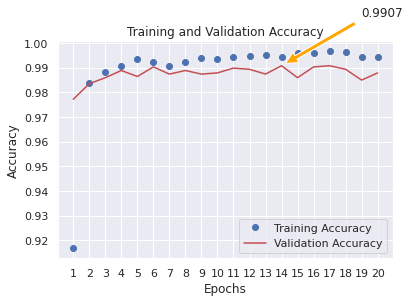

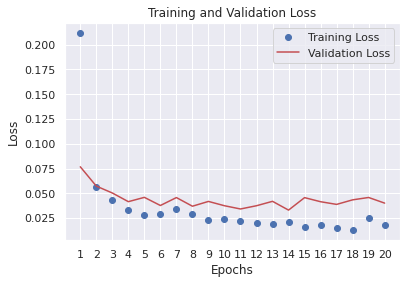

In [62]:
history = model_clean_data.history

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
y_arrow = max(val_acc)
x_arrow = val_acc.index(y_arrow) + 1
plt.annotate(str(y_arrow)[:6],
             (x_arrow, y_arrow),
             xytext=(x_arrow + 5, y_arrow + .02),
             arrowprops=dict(facecolor='orange', shrink=0.05))
plt.xticks(epochs)

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
plt.show()

In [63]:
def sentence_to_indices(sentence_words, max_len):
    X = np.zeros((max_len))
    sentence_indices = []
    for j, w in enumerate(sentence_words):
        try:
            index = word_to_index[w]
        except:
            w = cleared(w)
            try:
                index = word_to_index[w]
            except:
                index = word_to_index['unk']
        X[j] = index
    return X

def predict_custom_tweet_sentiment(custom_tweet):
    # Convert the tweet such that it can be fed to the model
    x_input = sentence_to_indices(remove_noise(tk.tokenize(custom_tweet)), max_len)
    
    # Retrun the model's prediction
    return model_clean_data.predict(np.array([x_input])).item()

In [64]:
predict_custom_tweet_sentiment("I'm happy you're here!")

0.0001327149075223133

In [65]:
predict_custom_tweet_sentiment("anxiety")

0.9318959712982178

In [66]:
predict_custom_tweet_sentiment("happy")

0.0012456529075279832

In [67]:
predict_custom_tweet_sentiment("I'm not happy you're here!")

0.00015682766388636082

In [68]:
def i_to_sentence(I):
    sentence = ""
    for i in I:
        if i:
            sentence += index_to_word[int(i)] + " "
        else:
            break
    return sentence

In [69]:
C = 0

pred = model_clean_data.predict(X_test)

for i in range(len(X_test)):
    final_pred = 1 if pred[i] > 0.5 else 0
    
    if(final_pred != Y_test[i]):
        print('Expected sentiment: ' + str(int(Y_test[i])) + '. Input: ' + i_to_sentence(X_test[i]))
        C += 1
        
    if C > 100:
        break

Expected sentiment: 1. Input: here my loves they have many amazing fics for these two especially stuff that unk happened in season two a 
Expected sentiment: 1. Input: lack of sexual interest is a symptom of unk that explains sooo much 
Expected sentiment: 1. Input: unk rap ã ¢ â â unk 
Expected sentiment: 1. Input: i love new clothes if everyone could just wear new clothes everyday i reckon unk ¢ â â unk 
Expected sentiment: 1. Input: worm dont have to engage in capitalism worms dont have unk gonna amputate my spine so i may become worm kin 
Expected sentiment: 0. Input: business case for iso 27001 our client has received confirmation that having become certified unk not lose their ã unk â £ 500,000 contract 
Expected sentiment: 0. Input: comment to previous tweet ã unk â « the car i will never buy unless i change my life in the most severe unk unk â » 
Expected sentiment: 1. Input: well ... another unk another unk unk today unk chill music and relaxed unk starts at 16:00 4 utc see ya